#### Continuing from `fixed_points.ipynb`, too bloated

In [1]:
import os
os.chdir('../..')

import torch

from tqdm import tqdm
from torch import Tensor as _T

from ddpm.model.main.multiepoch import MultiPreparatoryHVAEReverseProcess

from ddpm.utils.loading import generate_model_and_task_from_args_path_multiepoch

from purias_utils.multiitem_working_memory.util.circle_utils import rectify_angles, polar2cart

from sklearn.decomposition import PCA

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.cm as cmx
import matplotlib.colors as colors

from analysis.new_analysis.plane_alignment_utils import *


import numpy as np
from scipy.spatial.distance import pdist

In [2]:

base_dir_name = 'hvae_with_dendritic_20250410'

device = 'cuda'


# analysis_args = ConfigNamepace.from_yaml_path(sys.argv[1], strict_access = True)
# yaml_name = sys.argv[1].split('/')[-1].split('.')[0]
# save_base = '/homes/pr450/repos/research_projects/sampling_ddpm/results_link_sampler/analysis/fixed_points'
# save_path = os.path.join(save_base, yaml_name)
# _, save_path, _ = configure_logging_paths(save_path, [])
# analysis_args.write_to_yaml(os.path.join(save_path, "args.yaml"))
# print(save_path)
# run_name = analysis_args.run_name


# # run_name = 'run_a2_probe_cued_rnn_no_swap_1'
# # run_name = 'run_a3_probe_cued_diffusion_no_swap_1'
# # run_name = 'run_a4_probe_cued_diffusion_flat_swap_1'
# # run_name = 'run_a5_probe_cued_diffusion_cyclical_swap_0'
# # run_name = 'run_a6_probe_cued_diffusion_sharp_swap_2'


#run_name = 'run_a3_probe_cued_diffusion_no_swap_1'
#run_name = 'run_a4b_probe_cued_diffusion_flat_less_swap_0'
#run_name = 'run_a4c_probe_cued_diffusion_flat_even_less_swap_0'
run_name = 'run_a5b_probe_cued_diffusion_cyclical_less_swap_0'
#run_name = 'run_a5c_probe_cued_diffusion_cyclical_less_swap_more_0'

#run_name = 'run_c2_index_cued_diffusion_no_swap_1'
#run_name = 'run_c3_index_cued_diffusion_0.05_swap_0'
#run_name = 'run_c3_index_cued_diffusion_0.1_swap_0'




_, task, ddpm_model, _, _ = generate_model_and_task_from_args_path_multiepoch(f'/homes/pr450/repos/research_projects/sampling_ddpm/results_link_sampler/{base_dir_name}/{run_name}/args.yaml', device)
ddpm_model.load_state_dict(torch.load(f'/homes/pr450/repos/research_projects/sampling_ddpm/results_link_sampler/{base_dir_name}/{run_name}/state.mdl', weights_only=True))
ddpm_model: MultiPreparatoryHVAEReverseProcess


for n, parameter in ddpm_model.named_parameters():
    parameter.required_grad = False


### Get all possible stimuli

In [3]:
grid_points = 24
minimum_margin = torch.pi / task.task_variable_gen.min_sep

# Create unique feature values evenly spaced around the circle
unique_feature_values = torch.linspace(0, 2 * torch.pi, grid_points+1)[:-1]
unique_feature_values = rectify_angles(unique_feature_values)

# Create all possible combinations
stim1_grid, stim2_grid = torch.meshgrid(unique_feature_values, unique_feature_values, indexing='ij')
stim1_probe_features = stim1_grid.reshape(-1, 1)
stim2_probe_features = stim2_grid.reshape(-1, 1)

# Stack them together
all_possible_probe_features = torch.cat([stim1_probe_features, stim2_probe_features], dim=1)
all_possible_report_features = all_possible_probe_features.clone()

all_possible_probe_features = all_possible_probe_features.unsqueeze(1).repeat(1, grid_points * grid_points, 1).reshape(grid_points ** 4, 2)
all_possible_report_features = all_possible_report_features.unsqueeze(0).repeat(grid_points * grid_points, 1, 1).reshape(grid_points ** 4, 2)

all_possible_probe_features = all_possible_probe_features.repeat(2, 1)
all_possible_report_features = all_possible_report_features.repeat(2, 1)

# Create mask for valid combinations (respecting minimum margin)
probe_angle_diff = rectify_angles(all_possible_probe_features[:,0] - all_possible_probe_features[:,1])
report_angle_diff = rectify_angles(all_possible_report_features[:,0] - all_possible_report_features[:,1])
valid_trial_mask = (probe_angle_diff.abs() > minimum_margin) & (report_angle_diff.abs() > minimum_margin)

all_possible_selected_feature_idx = torch.concat([torch.zeros(grid_points ** 4), torch.ones(grid_points ** 4)]).int()

selected_feature_idx = all_possible_selected_feature_idx[valid_trial_mask]
all_probe_features = all_possible_probe_features[valid_trial_mask]
all_report_features = all_possible_report_features[valid_trial_mask]

/scratch/anaconda3/envs/torch_v2/lib/python3.12/site-packages/torch/_tensor.py:1488: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at /home/conda/feedstock_root/build_artifacts/libtorch_1736187088862/work/c10/core/TensorImpl.h:1928.)
  return super().rename(names)


### Fix one probe combination and run many trials

In [4]:
@torch.no_grad()
def generate_novel_samples_with_fixed_cues(fixed_probe1_val: float, fixed_probe2_val: float, num_samples: int):

    fixed_probe_pair_mask = ((all_probe_features[:,0] == fixed_probe1_val) & (all_probe_features[:,1] == fixed_probe2_val))
    fixed_probe_batch_size = fixed_probe_pair_mask.sum()

    override_stimulus_features = {
        'probe_features': all_probe_features[fixed_probe_pair_mask],
        'report_features': all_report_features[fixed_probe_pair_mask],
    }
    override_stimulus_cart_features = {}
    for k in override_stimulus_features.keys():
        override_stimulus_cart_features[f'{k}_cart'] = torch.stack(polar2cart(1.0, override_stimulus_features[k]), -1)

    override_stimulus_features_dict = dict(
        **override_stimulus_features,
        **override_stimulus_cart_features,
        cued_item_idx = selected_feature_idx[fixed_probe_pair_mask]
    )

    task_variable_dict = task.task_variable_gen.generate_variable_dict(
        batch_size = fixed_probe_batch_size,
        override_stimulus_features_dict=override_stimulus_features_dict
    )

    trial_information = task.generate_trial_information(
        batch_size=fixed_probe_batch_size, num_samples=num_samples, override_task_variable_information = task_variable_dict
    )

    novel_samples_prep_dicts, novel_samples_dict = ddpm_model.generate_samples(
        prep_network_inputs = trial_information.prep_network_inputs,
        diffusion_network_inputs = trial_information.diffusion_network_inputs,
        prep_epoch_durations=trial_information.prep_epoch_durations,
        diffusion_epoch_durations=trial_information.diffusion_epoch_durations,
        samples_shape=[fixed_probe_batch_size, num_samples],
        noise_scaler=1.0,
    )
    
    return novel_samples_prep_dicts, novel_samples_dict, fixed_probe_batch_size, override_stimulus_features_dict



def calculate_swapped_trials(novel_samples_dict: dict, batch_size: int, num_samples: int, input_information: dict, display: bool,):
    selected_report_value = torch.arctan2(*novel_samples_dict['samples'][...,[1,0]].permute(2, 0, 1))
    flattened_selected_report_value = selected_report_value.reshape(batch_size * num_samples)


    actual_errors = rectify_angles(selected_report_value - input_information['report_features'][range(batch_size), input_information['cued_item_idx'], None]).numpy()
    swapped_errors = rectify_angles(selected_report_value - input_information['report_features'][range(batch_size), 1 - input_information['cued_item_idx'], None]).numpy()
    
    swapped_trials = torch.tensor(np.abs(actual_errors) > np.abs(swapped_errors)).bool()

    if display:
        fig = plt.figure(figsize = (10, 5))
        plt.hist(actual_errors.flatten(), 250, density = True)
        plt.hist(swapped_errors.flatten(), 250, density = True)
        plt.show()

        print('swapped rate:', swapped_trials.float().mean())

    return flattened_selected_report_value, swapped_trials




def seperate_activities(epoch: str, t_in_epoch: int, input_information, swapped_trials, fixed_probe_batch_size, num_samples, flattened_selected_report_value, novel_samples_dict = None, novel_samples_prep_dicts = None):

    stim1_cued_mask_flattened = (input_information['cued_item_idx'] == 0.0).unsqueeze(1).expand(fixed_probe_batch_size, num_samples).flatten()
    swapped_trials_mask_flattened = swapped_trials.flatten()

    stim1_selected_mask_flattened = (stim1_cued_mask_flattened & ~swapped_trials_mask_flattened)# | (~stim1_cued_mask_flattened & swapped_trials_mask_flattened)
    stim2_selected_mask_flattened = (~stim1_cued_mask_flattened & ~swapped_trials_mask_flattened)# | (stim1_cued_mask_flattened & swapped_trials_mask_flattened)

    if epoch == 'precue':
        pcaable_activity = novel_samples_prep_dicts[1]['preparatory_trajectory'].data[:,:,t_in_epoch,:].cpu().reshape(fixed_probe_batch_size * num_samples, -1) @ ddpm_model.behaviour_nullspace_accessor.cpu()
    elif epoch == 'postcue':
        # pcaable_activity = novel_samples_prep_dicts[3]['preparatory_trajectory'].data[:,:,-1,:].cpu().reshape(fixed_probe_batch_size * num_samples, -1) @ ddpm_model.behaviour_nullspace_accessor.cpu()
        pcaable_activity = novel_samples_dict['embedded_sample_trajectory'].data[:,:,t_in_epoch,:].cpu().reshape(fixed_probe_batch_size * num_samples, -1) @ ddpm_model.behaviour_nullspace_accessor.cpu()
    elif epoch == 'durcue':
        pcaable_activity = novel_samples_prep_dicts[2]['preparatory_trajectory'].data[:,:,t_in_epoch,:].cpu().reshape(fixed_probe_batch_size * num_samples, -1) @ ddpm_model.behaviour_nullspace_accessor.cpu()
    else:
        raise ValueError(epoch)


    pcaable_activity = pcaable_activity - pcaable_activity.mean(-1, keepdim = True)
    pca_obj_all_activity = PCA(n_components=3, whiten = False).fit(pcaable_activity)
    pcaeed_activity = pca_obj_all_activity.transform(pcaable_activity)

    activity_for_stim1 = pcaeed_activity[stim1_selected_mask_flattened]
    activity_for_stim2 = pcaeed_activity[stim2_selected_mask_flattened]
    colors_for_stim1 = flattened_selected_report_value[stim1_selected_mask_flattened]
    colors_for_stim2 = flattened_selected_report_value[stim2_selected_mask_flattened]

    # if epoch == 'precue':
    #     activity_for_stim1 = pcaeed_activity
    #     activity_for_stim2 = pcaeed_activity
    #     colors_for_stim1 = input_information['report_features'][:,0].unsqueeze(1).repeat(1, num_samples).flatten()
    #     colors_for_stim2 = input_information['report_features'][:,1].unsqueeze(1).repeat(1, num_samples).flatten()

    # elif epoch == 'postcue' or epoch == 'durcue':
    #     activity_for_stim1 = pcaeed_activity[stim1_selected_mask_flattened]
    #     activity_for_stim2 = pcaeed_activity[stim2_selected_mask_flattened]
    #     colors_for_stim1 = flattened_selected_report_value[stim1_selected_mask_flattened]
    #     colors_for_stim2 = flattened_selected_report_value[stim2_selected_mask_flattened]

    # else:
    #     raise ValueError(epoch)

    return {
        'activity_for_stim1': activity_for_stim1,
        'colors_for_stim1': colors_for_stim1,
        'activity_for_stim2': activity_for_stim2,
        'colors_for_stim2': colors_for_stim2,
        'pca_obj_all_activity': pca_obj_all_activity,
    }



def get_plane_angles(epoch: str, t_in_epoch: int, input_information, swapped_trials, fixed_probe_batch_size, num_samples, flattened_selected_report_value, display: bool, novel_samples_dict = None, novel_samples_prep_dicts = None):

    seperate_activities_info = seperate_activities(
        epoch = epoch,
        t_in_epoch = t_in_epoch,
        input_information = input_information,
        swapped_trials = swapped_trials,
        fixed_probe_batch_size = fixed_probe_batch_size,
        num_samples = num_samples,
        flattened_selected_report_value = flattened_selected_report_value,
        novel_samples_dict = novel_samples_dict,
        novel_samples_prep_dicts = novel_samples_prep_dicts,
    )

    activity_for_stim1 = seperate_activities_info['activity_for_stim1']
    colors_for_stim1 = seperate_activities_info['colors_for_stim1']
    activity_for_stim2 = seperate_activities_info['activity_for_stim2']
    colors_for_stim2 = seperate_activities_info['colors_for_stim2']
    pca_obj_all_activity = seperate_activities_info['pca_obj_all_activity']

    mean_activity_per_bin_stim1_selected, mean_bin_values_stim1_selected = bin_values(activity_for_stim1, colors_for_stim1, 16)
    mean_activity_per_bin_stim2_selected, mean_bin_values_stim2_selected = bin_values(activity_for_stim2, colors_for_stim2, 16)

    plane_angle_cos, plane_angle = compare_planes(mean_activity_per_bin_stim1_selected, mean_activity_per_bin_stim2_selected)[:2]


    if display:
        fig = plt.figure(figsize=(20, 7))
        fig.suptitle(f'{pca_obj_all_activity.explained_variance_ratio_.cumsum().tolist()}')
        ax3d = fig.add_subplot(1, 2, 1, projection = '3d')
        ax3d.scatter(*mean_activity_per_bin_stim1_selected.T, c = mean_bin_values_stim1_selected, marker = 'o')
        ax3d.plot(*mean_activity_per_bin_stim1_selected.T, marker = None, color = 'grey')
        ax3d.scatter(*mean_activity_per_bin_stim2_selected.T, c = mean_bin_values_stim2_selected, marker = 'v')
        ax3d.plot(*mean_activity_per_bin_stim2_selected.T, marker = None, color = 'grey')
        ax3d.legend()


        ax = fig.add_subplot(1, 2, 2)
        double_pca_obj = PCA(3, whiten = False).fit(mean_activity_per_bin_stim1_selected)
        double_pca_stim1_space = double_pca_obj.transform(mean_activity_per_bin_stim1_selected)
        double_pca_stim2_space = double_pca_obj.transform(mean_activity_per_bin_stim2_selected)
        ax.scatter(*double_pca_stim1_space.T[:2], c = mean_bin_values_stim1_selected, marker = 'o')
        ax.scatter(*double_pca_stim2_space.T[:2], c = mean_bin_values_stim1_selected, marker = 'v')
        ax.plot(*double_pca_stim1_space.T[:2], marker = None, color = 'grey')
        ax.plot(*double_pca_stim2_space.T[:2], marker = None, color = 'grey')
        ax.set_title(f'plane_angle = {plane_angle}\nCos(plane angle) = {plane_angle_cos}')

    else:
        fig, ax, ax3d = None, None, None
    
    return {
        "plane_angle_cos": plane_angle_cos,
        "plane_angle": plane_angle,
        "fig": fig,
        "ax3d": ax3d,
        "ax": ax,
        **seperate_activities_info,
    }

In [5]:
num_precue_steps, num_cue_steps, num_postcue_steps = 15, 5, 20


all_probe_val_idx_diffs = range(3, 12) if 'probe' in run_name else [12]
all_fixed_probe1_val_idxs = range(24) if 'probe' in run_name else [0]
num_samples = 32 if 'probe' in run_name else 64

In [12]:
all_diffs = []
all_precue_plane_angle_coses_for_diffs = []

for val_idx_diff in all_probe_val_idx_diffs:

    print(f'Starting diff {val_idx_diff}')

    precue_plane_angle_coses_for_diff = []

    for fixed_probe1_val_idx in all_fixed_probe1_val_idxs:

        fixed_probe2_val_idx = (fixed_probe1_val_idx + val_idx_diff) % grid_points

        fixed_probe1_val = unique_feature_values[fixed_probe1_val_idx]
        fixed_probe2_val = unique_feature_values[fixed_probe2_val_idx]

        outer_novel_samples_prep_dicts, outer_novel_samples_dict, fixed_probe_batch_size, outer_input_information = generate_novel_samples_with_fixed_cues(fixed_probe1_val, fixed_probe2_val, num_samples)

        flattened_selected_report_value, swapped_trials = calculate_swapped_trials(novel_samples_dict = outer_novel_samples_dict, batch_size = fixed_probe_batch_size, num_samples = num_samples, input_information = outer_input_information, display = False)

        precue_plane_angle_coses = []

        for i in range(num_precue_steps):
            activity_info = get_plane_angles('precue', i, outer_input_information, swapped_trials, fixed_probe_batch_size, num_samples, flattened_selected_report_value, display = False, novel_samples_dict = outer_novel_samples_dict, novel_samples_prep_dicts = outer_novel_samples_prep_dicts)
            precue_plane_angle_coses.append(activity_info['plane_angle_cos'])

        for i in range(num_cue_steps):
            activity_info = get_plane_angles('durcue', i, outer_input_information, swapped_trials, fixed_probe_batch_size, num_samples, flattened_selected_report_value, display = False, novel_samples_dict = outer_novel_samples_dict, novel_samples_prep_dicts = outer_novel_samples_prep_dicts)
            precue_plane_angle_coses.append(activity_info['plane_angle_cos'])

        for i in range(num_postcue_steps):
            activity_info = get_plane_angles('postcue', i, outer_input_information, swapped_trials, fixed_probe_batch_size, num_samples, flattened_selected_report_value, display = False, novel_samples_dict = outer_novel_samples_dict, novel_samples_prep_dicts = outer_novel_samples_prep_dicts)
            precue_plane_angle_coses.append(activity_info['plane_angle_cos'])

        #fig, axes = plt.subplots(1, 2, figsize = (10, 5))
        #axes[0].plot(precue_plane_angle_coses)

        precue_plane_angle_coses_for_diff.append(precue_plane_angle_coses)

    all_precue_plane_angle_coses_for_diffs.append(precue_plane_angle_coses_for_diff)
    all_diffs.append(val_idx_diff)


all_precue_plane_angle_coses_for_diffs = np.array(all_precue_plane_angle_coses_for_diffs)
np.save(f'/homes/pr450/repos/research_projects/sampling_ddpm/results_link_sampler/analysis/plane_alignment/all_precue_plane_angle_coses_for_diffs_{run_name}.npy', all_precue_plane_angle_coses_for_diffs)

Starting diff 3
USING PRECUED ITEMS - SHOULD NEVER BE DONE IN TRAINING
USING PRECUED ITEMS - SHOULD NEVER BE DONE IN TRAINING
USING PRECUED ITEMS - SHOULD NEVER BE DONE IN TRAINING
USING PRECUED ITEMS - SHOULD NEVER BE DONE IN TRAINING
USING PRECUED ITEMS - SHOULD NEVER BE DONE IN TRAINING
USING PRECUED ITEMS - SHOULD NEVER BE DONE IN TRAINING
USING PRECUED ITEMS - SHOULD NEVER BE DONE IN TRAINING
USING PRECUED ITEMS - SHOULD NEVER BE DONE IN TRAINING
USING PRECUED ITEMS - SHOULD NEVER BE DONE IN TRAINING
USING PRECUED ITEMS - SHOULD NEVER BE DONE IN TRAINING
USING PRECUED ITEMS - SHOULD NEVER BE DONE IN TRAINING
USING PRECUED ITEMS - SHOULD NEVER BE DONE IN TRAINING
USING PRECUED ITEMS - SHOULD NEVER BE DONE IN TRAINING
USING PRECUED ITEMS - SHOULD NEVER BE DONE IN TRAINING
USING PRECUED ITEMS - SHOULD NEVER BE DONE IN TRAINING
USING PRECUED ITEMS - SHOULD NEVER BE DONE IN TRAINING
USING PRECUED ITEMS - SHOULD NEVER BE DONE IN TRAINING
USING PRECUED ITEMS - SHOULD NEVER BE DONE IN TRA

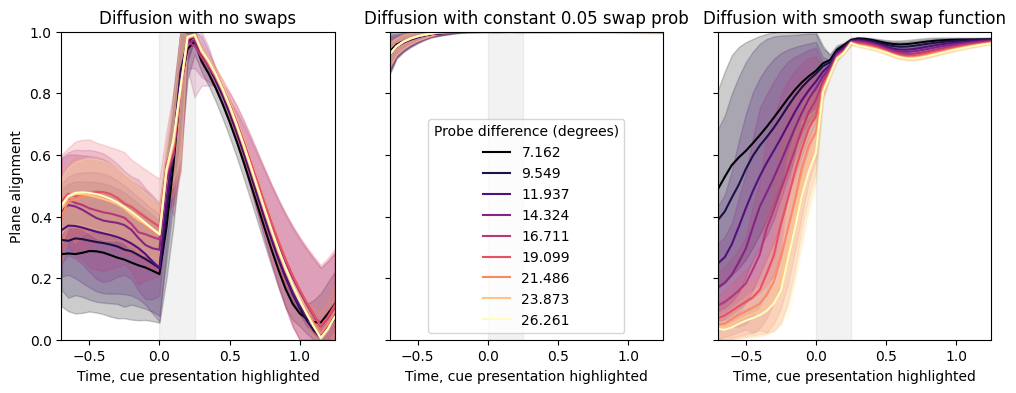

In [13]:
def generate_cmap(lrn: str, all_probe_val_idx_diffs: list[int]):
    magma = plt.get_cmap("magma")
    cNorm = colors.Normalize(vmin=all_probe_val_idx_diffs[0], vmax=all_probe_val_idx_diffs[-1])
    cmap = cmx.ScalarMappable(norm=cNorm, cmap=magma)
    cmap.set_array([])
    return cmap

dt = 0.05

# loading_run_names = {
#     'run_a3_probe_cued_diffusion_no_swap_1': 'Diffusion with no swaps',
#     'run_a4c_probe_cued_diffusion_flat_even_less_swap_0': 'Diffusion with constant 0.05 swap prob',
#     #'run_a4b_probe_cued_diffusion_flat_less_swap_0': 'Diffusion with constant 0.08 swap prob',
#     'run_a5b_probe_cued_diffusion_cyclical_less_swap_0': 'Diffusion with smooth swap function',
# }

loading_run_names = {
    'run_c3_index_cued_diffusion_0.05_swap_0': '0.05',
    'run_c3_index_cued_diffusion_0.1_swap_0': '0.1',
    'run_c3_index_cued_diffusion_0.05_swap_0': '0.00',
}

figsize = 4
fig, axes = plt.subplots(1, len(loading_run_names), figsize = (len(loading_run_names) * figsize, figsize), sharey =True)

axes[0].set_ylabel('Plane alignment')

for ax, loading_run_name in zip(axes, loading_run_names.keys()):

    with open(f'/homes/pr450/repos/research_projects/sampling_ddpm/results_link_sampler/analysis/plane_alignment/all_precue_plane_angle_coses_for_diffs_{loading_run_name}.npy', 'rb') as f:
        all_precue_plane_angle_coses_for_diffs = np.load(f, allow_pickle=True)

    means = all_precue_plane_angle_coses_for_diffs.mean(1)
    stds = all_precue_plane_angle_coses_for_diffs.std(1)

    time_axis = [(i - num_precue_steps) * dt for i in range(1, 1 + means.shape[-1])]
    cmap = generate_cmap(loading_run_name, all_probe_val_idx_diffs)

    for (diff, mean_line, std_line) in zip(all_probe_val_idx_diffs, means, stds):
        
        upper = np.clip(mean_line + std_line, 0.0, 1.0)
        lower = np.clip(mean_line - std_line, 0.0, 1.0)

        probe_diff = diff / 24 / np.pi * 180          ### XXX: Hacky - save probe diffs directly!

        ax.plot(time_axis, mean_line, color = cmap.to_rgba(diff), label = round(probe_diff, 3))
        ax.fill_between(time_axis, lower, upper, alpha = 0.2, color = cmap.to_rgba(diff))

    ylim = ax.get_ylim()

    ax.fill_betweenx(
        ylim, 
        (np.array([num_precue_steps, num_precue_steps]) - num_precue_steps) * dt,
        (np.array([num_cue_steps + num_precue_steps, num_cue_steps + num_precue_steps]) - num_precue_steps) * dt,
        alpha = 0.1, color = 'grey'
    )

    ax.set_ylim(ylim)
    ax.set_xlabel('Time, cue presentation highlighted')
    ax.set_title(loading_run_names[loading_run_name])

    ax.set_ylim(0.0, 1.0)
    ax.set_xlim(time_axis[0], time_axis[-1])


axes[1].legend(title = 'Probe difference (degrees)', loc='lower center') 

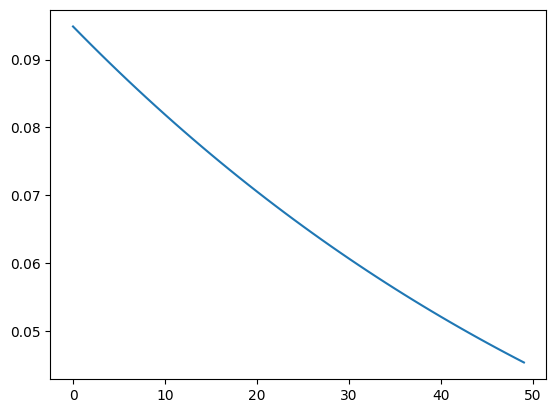

In [26]:
task.task_variable_gen.swap_function_width, task.task_variable_gen.swap_function_offset
test_points = 50

test_range = torch.linspace(torch.pi / task.task_variable_gen.min_sep, torch.pi, test_points)
test_cued_probe_sq_distance = torch.stack([0.0 * test_range, test_range], 1)

swap_func = -0.5 * (test_cued_probe_sq_distance / (task.task_variable_gen.swap_function_width + 2e-5)) 
swap_func[range(test_points), 0] -= task.task_variable_gen.swap_function_offset

plt.plot(swap_func.softmax(-1)[:,1])

## Misprojection

In [16]:
def generate_many_trials_data(fixed_probe1_val_idx: int, fixed_probe2_val_idx: int, plot: bool = False):
    fixed_probe1_val = unique_feature_values[fixed_probe1_val_idx]
    fixed_probe2_val = unique_feature_values[fixed_probe2_val_idx]

    novel_samples_prep_dicts, novel_samples_dict, fixed_probe_batch_size, input_information = generate_novel_samples_with_fixed_cues(fixed_probe1_val, fixed_probe2_val, num_samples)
    flattened_selected_report_value, swapped_trials = calculate_swapped_trials(novel_samples_dict = novel_samples_dict, batch_size = fixed_probe_batch_size, num_samples = num_samples, input_information = input_information, display = False)

    if plot:
        fig_precue = get_plane_angles('precue', -5, input_information, swapped_trials, fixed_probe_batch_size, num_samples, flattened_selected_report_value, display = True, novel_samples_dict = novel_samples_dict, novel_samples_prep_dicts = novel_samples_prep_dicts)
        fig_postcue = get_plane_angles('postcue', 4, input_information, swapped_trials, fixed_probe_batch_size, num_samples, flattened_selected_report_value, display = True, novel_samples_dict = novel_samples_dict, novel_samples_prep_dicts = novel_samples_prep_dicts)

        fig_precue['fig'].suptitle('5 steps before cue onset')
        fig_postcue['fig'].suptitle('5 steps after cue offset')

        fig_precue['ax3d'].xaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
        fig_postcue['ax3d'].xaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
        fig_precue['ax3d'].yaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
        fig_postcue['ax3d'].yaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
        fig_precue['ax3d'].zaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
        fig_postcue['ax3d'].zaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))

    return novel_samples_prep_dicts, novel_samples_dict, fixed_probe_batch_size, input_information, flattened_selected_report_value, swapped_trials

In [86]:
def generate_misprojection_planes(fixed_stim_value_idx, input_information, novel_samples_dict, novel_samples_prep_dicts, plot: bool = False):

    fixed_stim1_value = unique_feature_values[fixed_stim_value_idx]        

    stim1_cued_mask = (input_information['cued_item_idx'] == 0) & (input_information['report_features'][:,0] == fixed_stim1_value)
    stim2_cued_mask = (input_information['cued_item_idx'] == 1) & (input_information['report_features'][:,0] == fixed_stim1_value)

    stim2_report_when_stim1_cued = input_information['report_features'][stim1_cued_mask][:,1]
    stim2_report_when_stim1_distractor = input_information['report_features'][stim2_cued_mask][:,1]

    final_timestep_many_trials_data = novel_samples_dict['embedded_sample_trajectory'].data[:,:,-1,:].cpu() @ ddpm_model.behaviour_nullspace_accessor.cpu()
    # final_timestep_many_trials_data = novel_samples_prep_dicts[1]['preparatory_trajectory'].data[:,:,-1].cpu() @ ddpm_model.behaviour_nullspace_accessor.cpu()

    stim1_as_cued_many_trials_data = final_timestep_many_trials_data[stim1_cued_mask]
    stim1_as_distractor_many_trials_data = final_timestep_many_trials_data[stim2_cued_mask]
    stim1_as_cued_many_trials_data_reshaped = stim1_as_cued_many_trials_data.reshape(num_samples * stim1_as_cued_many_trials_data.shape[0], ddpm_model.sample_ambient_dims[0])
    stim1_as_distractor_many_trials_data_reshaped = stim1_as_distractor_many_trials_data.reshape(num_samples * stim1_as_distractor_many_trials_data.shape[0], ddpm_model.sample_ambient_dims[0])

    stim2_report_when_stim1_cued_many_trials = stim2_report_when_stim1_cued.unsqueeze(1).repeat(1, num_samples).reshape(-1)
    stim2_report_when_stim1_distractor_many_trials = stim2_report_when_stim1_distractor.unsqueeze(1).repeat(1, num_samples).reshape(-1)

    pca_obj_stim1_as_cued_many_trials = PCA(n_components=4, whiten = False).fit(stim1_as_cued_many_trials_data_reshaped)

    pcaed_stim1_as_cued_many_trials_reshaped = pca_obj_stim1_as_cued_many_trials.transform(stim1_as_cued_many_trials_data_reshaped)
    
    if plot:
        pcaed_stim1_as_distractor_many_trials_reshaped = pca_obj_stim1_as_cued_many_trials.transform(stim1_as_distractor_many_trials_data_reshaped)

        fig_stim1 = plt.figure(figsize = (15, 5))
        ax_color_by_report = fig_stim1.add_subplot(1, 3, 1, projection = '3d')
        ax_color_by_report_stim1_distractor = fig_stim1.add_subplot(1, 3, 2, projection = '3d')
        ax_var_explained = fig_stim1.add_subplot(1, 3, 3)

        ax_color_by_report.set_title('Stim1 cued and fixed across dots.\nColor = stim2 report')
        ax_color_by_report_stim1_distractor.set_title('Stim2 cued, stim1 fixed across dots.\nColor = stim2 report.\nSame PCs as axis 1')
        ax_var_explained.set_title('Variance explained (cumulative ratio)')

        ax_color_by_report.scatter(*pcaed_stim1_as_cued_many_trials_reshaped[~swapped_trials[stim1_cued_mask].flatten()].T[:3], c = stim2_report_when_stim1_cued_many_trials[~swapped_trials[stim1_cued_mask].flatten()], label = 'correct trials')
        ax_color_by_report.scatter(*pcaed_stim1_as_cued_many_trials_reshaped[swapped_trials[stim1_cued_mask].flatten()].T[:3], c = stim2_report_when_stim1_cued_many_trials[swapped_trials[stim1_cued_mask].flatten()], marker = 'x', label = 'swapped trials')

        ax_color_by_report_stim1_distractor.scatter(*pcaed_stim1_as_distractor_many_trials_reshaped[~swapped_trials[stim2_cued_mask].flatten()].T[:3], c = stim2_report_when_stim1_distractor_many_trials[~swapped_trials[stim2_cued_mask].flatten()], label = 'correct trials')
        ax_color_by_report_stim1_distractor.scatter(*pcaed_stim1_as_distractor_many_trials_reshaped[swapped_trials[stim2_cued_mask].flatten()].T[:3], c = stim2_report_when_stim1_distractor_many_trials[swapped_trials[stim2_cued_mask].flatten()], marker = 'x', label = 'swapped trials')

        ax_color_by_report.legend()

        ax_color_by_report.xaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
        ax_color_by_report_stim1_distractor.xaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
        ax_color_by_report.yaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
        ax_color_by_report_stim1_distractor.yaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
        ax_color_by_report.zaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
        ax_color_by_report_stim1_distractor.zaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))

        ax_var_explained.plot(pca_obj_stim1_as_cued_many_trials.explained_variance_ratio_.cumsum())

    return fixed_stim1_value, pca_obj_stim1_as_cued_many_trials.components_, pcaed_stim1_as_cued_many_trials_reshaped, swapped_trials[stim1_cued_mask].flatten()

In [87]:
#run_name = 'run_a3_probe_cued_diffusion_no_swap_1'
#run_name = 'run_a4b_probe_cued_diffusion_flat_less_swap_0'
#run_name = 'run_a4c_probe_cued_diffusion_flat_even_less_swap_0'
#run_name = 'run_a5b_probe_cued_diffusion_cyclical_less_swap_0'
run_name = 'run_a5_probe_cued_diffusion_cyclical_swap_0'


_, task, ddpm_model, _, _ = generate_model_and_task_from_args_path_multiepoch(f'/homes/pr450/repos/research_projects/sampling_ddpm/results_link_sampler/{base_dir_name}/{run_name}/args.yaml', device)
ddpm_model.load_state_dict(torch.load(f'/homes/pr450/repos/research_projects/sampling_ddpm/results_link_sampler/{base_dir_name}/{run_name}/state.mdl', weights_only=True))
ddpm_model: MultiPreparatoryHVAEReverseProcess
for n, parameter in ddpm_model.named_parameters():
    parameter.required_grad = False

### Note - the below is for the larger than realistic swap function!

USING PRECUED ITEMS - SHOULD NEVER BE DONE IN TRAINING


/tmp/ipykernel_4025324/2486677072.py:153: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax3d.legend()
/tmp/ipykernel_4025324/2486677072.py:153: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax3d.legend()


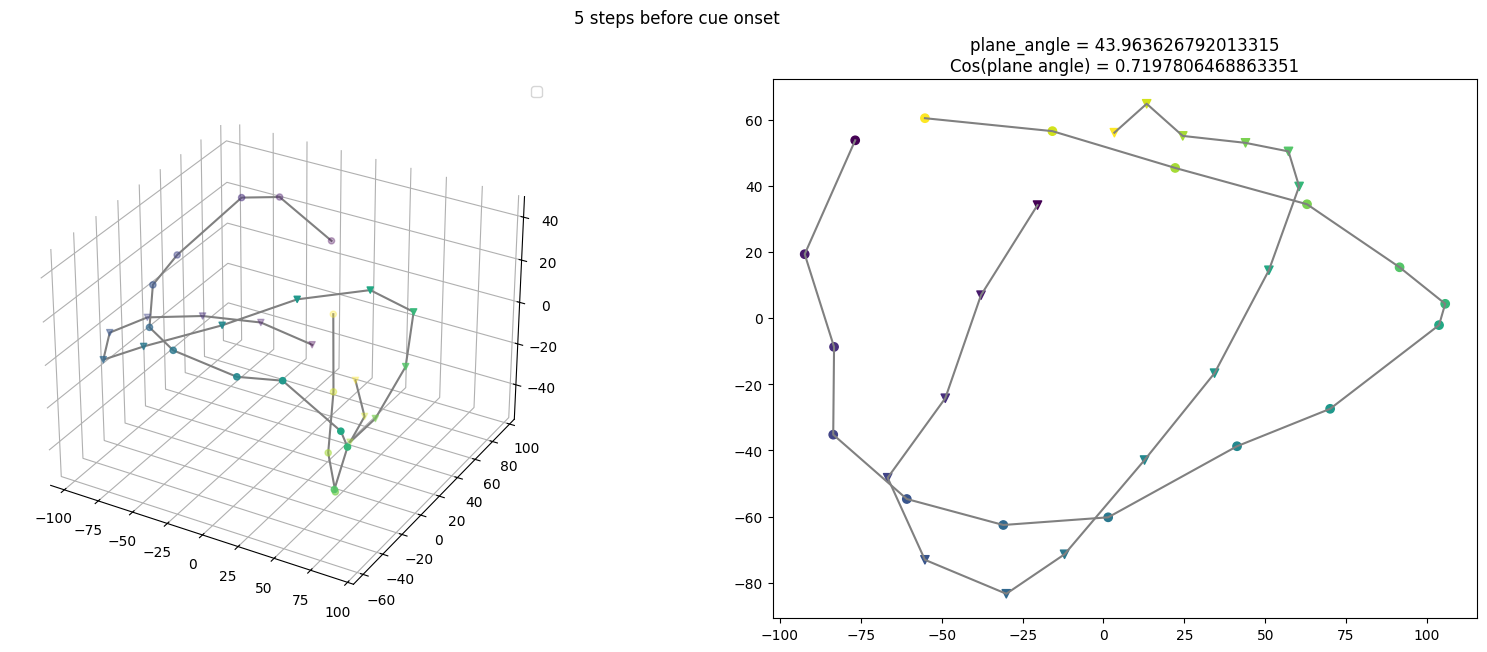

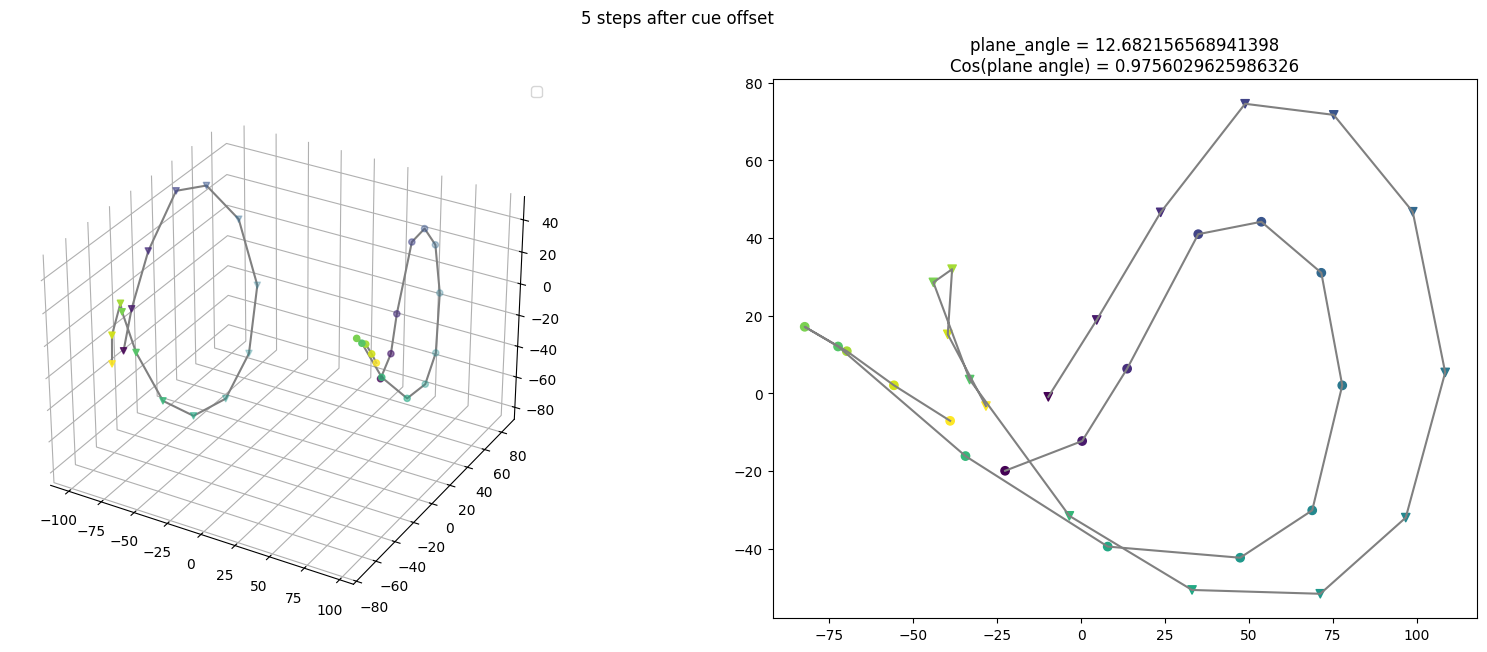

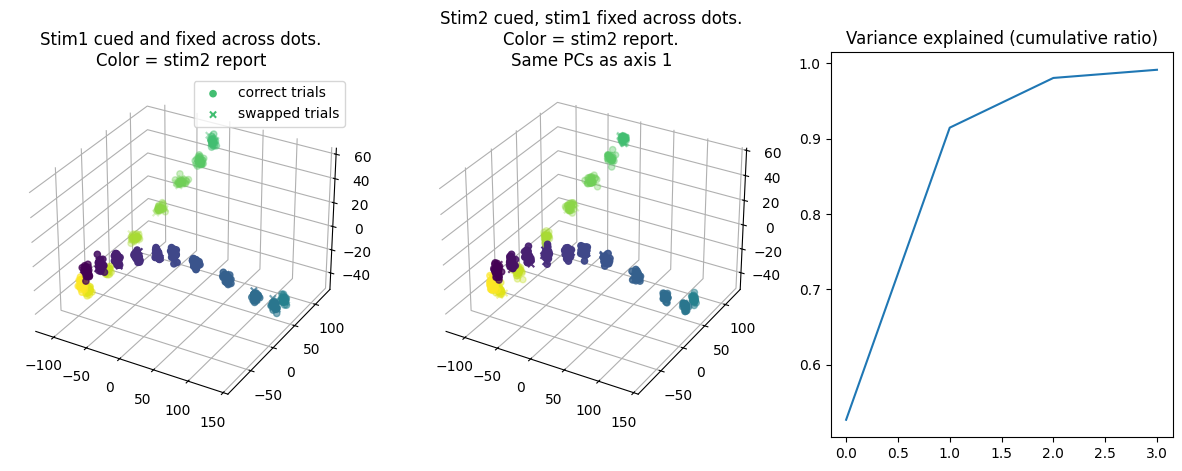

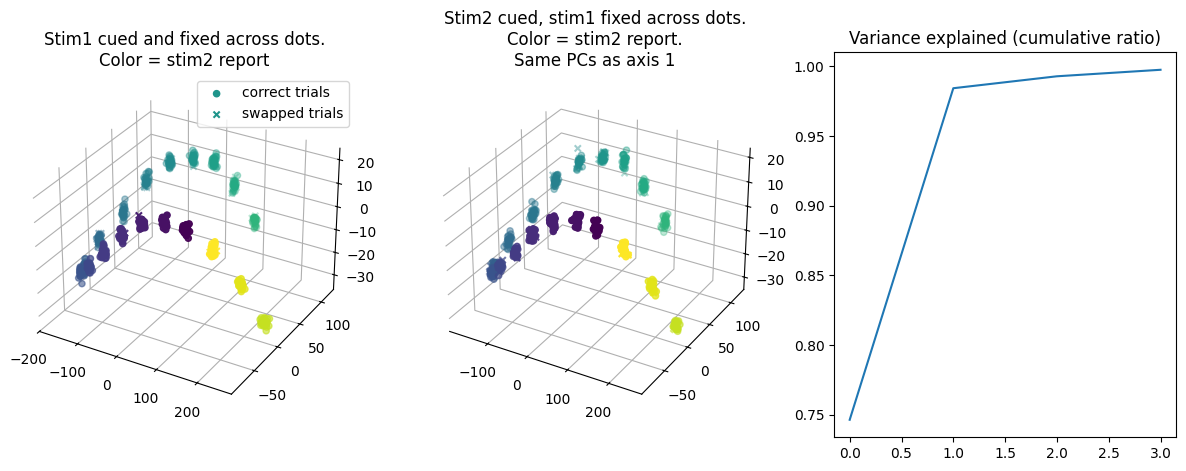

In [90]:
novel_samples_prep_dicts, novel_samples_dict, fixed_probe_batch_size, input_information, flattened_selected_report_value, swapped_trials = generate_many_trials_data(0, 11, True)
generate_misprojection_planes(1, input_information, novel_samples_dict, novel_samples_prep_dicts, plot=True), generate_misprojection_planes(6, input_information, novel_samples_dict, novel_samples_prep_dicts, plot=True)
pass

# For different probe features, but the same stim1 fix, we should have the same 3d subspaces above (2 for color + 1 for target vs. distractor)

In [92]:
for j in range(0, 1):
    all_fixed_probe_values = []
    all_post_comps = []
    all_projection_pcaed = []
    all_many_trials_swapped_trials = []

    for i1 in tqdm(range(0, 12)):
        for i2 in tqdm(range(0, 12)):
            try:
                novel_samples_prep_dicts, novel_samples_dict, fixed_probe_batch_size, input_information, flattened_selected_report_value, swapped_trials =\
                    generate_many_trials_data(i1, i2, False)
            except RuntimeError:
                continue

            fixed_stim1_value, new_post_comp, projection_pcaed, relevant_swapped_trials = generate_misprojection_planes(j, input_information, novel_samples_dict, novel_samples_prep_dicts, plot=False)
            all_fixed_probe_values.append(input_information['probe_features'][0].tolist())
            all_post_comps.append(new_post_comp)
            all_projection_pcaed.append(projection_pcaed)
            all_many_trials_swapped_trials.append(relevant_swapped_trials)

  0%|          | 0/12 [00:00<?, ?it/s]

USING PRECUED ITEMS - SHOULD NEVER BE DONE IN TRAINING
USING PRECUED ITEMS - SHOULD NEVER BE DONE IN TRAINING
USING PRECUED ITEMS - SHOULD NEVER BE DONE IN TRAINING
USING PRECUED ITEMS - SHOULD NEVER BE DONE IN TRAINING


USING PRECUED ITEMS - SHOULD NEVER BE DONE IN TRAINING


USING PRECUED ITEMS - SHOULD NEVER BE DONE IN TRAINING


USING PRECUED ITEMS - SHOULD NEVER BE DONE IN TRAINING


USING PRECUED ITEMS - SHOULD NEVER BE DONE IN TRAINING


USING PRECUED ITEMS - SHOULD NEVER BE DONE IN TRAINING


USING PRECUED ITEMS - SHOULD NEVER BE DONE IN TRAINING


USING PRECUED ITEMS - SHOULD NEVER BE DONE IN TRAINING


USING PRECUED ITEMS - SHOULD NEVER BE DONE IN TRAINING


  8%|▊         | 1/12 [00:04<00:48,  4.44s/it]

USING PRECUED ITEMS - SHOULD NEVER BE DONE IN TRAINING
USING PRECUED ITEMS - SHOULD NEVER BE DONE IN TRAINING
USING PRECUED ITEMS - SHOULD NEVER BE DONE IN TRAINING
USING PRECUED ITEMS - SHOULD NEVER BE DONE IN TRAINING
USING PRECUED ITEMS - SHOULD NEVER BE DONE IN TRAINING


USING PRECUED ITEMS - SHOULD NEVER BE DONE IN TRAINING
USING PRECUED ITEMS - SHOULD NEVER BE DONE IN TRAINING


USING PRECUED ITEMS - SHOULD NEVER BE DONE IN TRAINING


USING PRECUED ITEMS - SHOULD NEVER BE DONE IN TRAINING


USING PRECUED ITEMS - SHOULD NEVER BE DONE IN TRAINING


USING PRECUED ITEMS - SHOULD NEVER BE DONE IN TRAINING


USING PRECUED ITEMS - SHOULD NEVER BE DONE IN TRAINING


 17%|█▋        | 2/12 [00:08<00:41,  4.17s/it]

USING PRECUED ITEMS - SHOULD NEVER BE DONE IN TRAINING
USING PRECUED ITEMS - SHOULD NEVER BE DONE IN TRAINING
USING PRECUED ITEMS - SHOULD NEVER BE DONE IN TRAINING
USING PRECUED ITEMS - SHOULD NEVER BE DONE IN TRAINING
USING PRECUED ITEMS - SHOULD NEVER BE DONE IN TRAINING
USING PRECUED ITEMS - SHOULD NEVER BE DONE IN TRAINING


USING PRECUED ITEMS - SHOULD NEVER BE DONE IN TRAINING
USING PRECUED ITEMS - SHOULD NEVER BE DONE IN TRAINING


USING PRECUED ITEMS - SHOULD NEVER BE DONE IN TRAINING


USING PRECUED ITEMS - SHOULD NEVER BE DONE IN TRAINING


USING PRECUED ITEMS - SHOULD NEVER BE DONE IN TRAINING


USING PRECUED ITEMS - SHOULD NEVER BE DONE IN TRAINING


 25%|██▌       | 3/12 [00:11<00:34,  3.86s/it]

USING PRECUED ITEMS - SHOULD NEVER BE DONE IN TRAINING


USING PRECUED ITEMS - SHOULD NEVER BE DONE IN TRAINING
USING PRECUED ITEMS - SHOULD NEVER BE DONE IN TRAINING
USING PRECUED ITEMS - SHOULD NEVER BE DONE IN TRAINING
USING PRECUED ITEMS - SHOULD NEVER BE DONE IN TRAINING
USING PRECUED ITEMS - SHOULD NEVER BE DONE IN TRAINING
USING PRECUED ITEMS - SHOULD NEVER BE DONE IN TRAINING


USING PRECUED ITEMS - SHOULD NEVER BE DONE IN TRAINING


USING PRECUED ITEMS - SHOULD NEVER BE DONE IN TRAINING


USING PRECUED ITEMS - SHOULD NEVER BE DONE IN TRAINING


USING PRECUED ITEMS - SHOULD NEVER BE DONE IN TRAINING


USING PRECUED ITEMS - SHOULD NEVER BE DONE IN TRAINING


 33%|███▎      | 4/12 [00:15<00:29,  3.71s/it]

USING PRECUED ITEMS - SHOULD NEVER BE DONE IN TRAINING


USING PRECUED ITEMS - SHOULD NEVER BE DONE IN TRAINING


USING PRECUED ITEMS - SHOULD NEVER BE DONE IN TRAINING
USING PRECUED ITEMS - SHOULD NEVER BE DONE IN TRAINING
USING PRECUED ITEMS - SHOULD NEVER BE DONE IN TRAINING
USING PRECUED ITEMS - SHOULD NEVER BE DONE IN TRAINING
USING PRECUED ITEMS - SHOULD NEVER BE DONE IN TRAINING
USING PRECUED ITEMS - SHOULD NEVER BE DONE IN TRAINING


USING PRECUED ITEMS - SHOULD NEVER BE DONE IN TRAINING


USING PRECUED ITEMS - SHOULD NEVER BE DONE IN TRAINING


USING PRECUED ITEMS - SHOULD NEVER BE DONE IN TRAINING


USING PRECUED ITEMS - SHOULD NEVER BE DONE IN TRAINING


 42%|████▏     | 5/12 [00:18<00:25,  3.63s/it]

USING PRECUED ITEMS - SHOULD NEVER BE DONE IN TRAINING


USING PRECUED ITEMS - SHOULD NEVER BE DONE IN TRAINING


USING PRECUED ITEMS - SHOULD NEVER BE DONE IN TRAINING


USING PRECUED ITEMS - SHOULD NEVER BE DONE IN TRAINING
USING PRECUED ITEMS - SHOULD NEVER BE DONE IN TRAINING
USING PRECUED ITEMS - SHOULD NEVER BE DONE IN TRAINING
USING PRECUED ITEMS - SHOULD NEVER BE DONE IN TRAINING
USING PRECUED ITEMS - SHOULD NEVER BE DONE IN TRAINING
USING PRECUED ITEMS - SHOULD NEVER BE DONE IN TRAINING


USING PRECUED ITEMS - SHOULD NEVER BE DONE IN TRAINING


USING PRECUED ITEMS - SHOULD NEVER BE DONE IN TRAINING


USING PRECUED ITEMS - SHOULD NEVER BE DONE IN TRAINING


 50%|█████     | 6/12 [00:22<00:21,  3.58s/it]

USING PRECUED ITEMS - SHOULD NEVER BE DONE IN TRAINING


USING PRECUED ITEMS - SHOULD NEVER BE DONE IN TRAINING


USING PRECUED ITEMS - SHOULD NEVER BE DONE IN TRAINING


USING PRECUED ITEMS - SHOULD NEVER BE DONE IN TRAINING


USING PRECUED ITEMS - SHOULD NEVER BE DONE IN TRAINING
USING PRECUED ITEMS - SHOULD NEVER BE DONE IN TRAINING
USING PRECUED ITEMS - SHOULD NEVER BE DONE IN TRAINING
USING PRECUED ITEMS - SHOULD NEVER BE DONE IN TRAINING
USING PRECUED ITEMS - SHOULD NEVER BE DONE IN TRAINING
USING PRECUED ITEMS - SHOULD NEVER BE DONE IN TRAINING


USING PRECUED ITEMS - SHOULD NEVER BE DONE IN TRAINING


USING PRECUED ITEMS - SHOULD NEVER BE DONE IN TRAINING


 58%|█████▊    | 7/12 [00:25<00:17,  3.55s/it]

USING PRECUED ITEMS - SHOULD NEVER BE DONE IN TRAINING


USING PRECUED ITEMS - SHOULD NEVER BE DONE IN TRAINING


USING PRECUED ITEMS - SHOULD NEVER BE DONE IN TRAINING


USING PRECUED ITEMS - SHOULD NEVER BE DONE IN TRAINING


USING PRECUED ITEMS - SHOULD NEVER BE DONE IN TRAINING


USING PRECUED ITEMS - SHOULD NEVER BE DONE IN TRAINING
USING PRECUED ITEMS - SHOULD NEVER BE DONE IN TRAINING
USING PRECUED ITEMS - SHOULD NEVER BE DONE IN TRAINING
USING PRECUED ITEMS - SHOULD NEVER BE DONE IN TRAINING
USING PRECUED ITEMS - SHOULD NEVER BE DONE IN TRAINING
USING PRECUED ITEMS - SHOULD NEVER BE DONE IN TRAINING


USING PRECUED ITEMS - SHOULD NEVER BE DONE IN TRAINING


 67%|██████▋   | 8/12 [00:29<00:14,  3.53s/it]

USING PRECUED ITEMS - SHOULD NEVER BE DONE IN TRAINING


USING PRECUED ITEMS - SHOULD NEVER BE DONE IN TRAINING


USING PRECUED ITEMS - SHOULD NEVER BE DONE IN TRAINING


USING PRECUED ITEMS - SHOULD NEVER BE DONE IN TRAINING


USING PRECUED ITEMS - SHOULD NEVER BE DONE IN TRAINING


USING PRECUED ITEMS - SHOULD NEVER BE DONE IN TRAINING


USING PRECUED ITEMS - SHOULD NEVER BE DONE IN TRAINING
USING PRECUED ITEMS - SHOULD NEVER BE DONE IN TRAINING
USING PRECUED ITEMS - SHOULD NEVER BE DONE IN TRAINING
USING PRECUED ITEMS - SHOULD NEVER BE DONE IN TRAINING
USING PRECUED ITEMS - SHOULD NEVER BE DONE IN TRAINING
USING PRECUED ITEMS - SHOULD NEVER BE DONE IN TRAINING


 75%|███████▌  | 9/12 [00:32<00:10,  3.52s/it]

USING PRECUED ITEMS - SHOULD NEVER BE DONE IN TRAINING


USING PRECUED ITEMS - SHOULD NEVER BE DONE IN TRAINING


USING PRECUED ITEMS - SHOULD NEVER BE DONE IN TRAINING


USING PRECUED ITEMS - SHOULD NEVER BE DONE IN TRAINING


USING PRECUED ITEMS - SHOULD NEVER BE DONE IN TRAINING


USING PRECUED ITEMS - SHOULD NEVER BE DONE IN TRAINING


USING PRECUED ITEMS - SHOULD NEVER BE DONE IN TRAINING


 83%|████████▎ | 10/12 [00:36<00:07,  3.54s/it]

USING PRECUED ITEMS - SHOULD NEVER BE DONE IN TRAINING
USING PRECUED ITEMS - SHOULD NEVER BE DONE IN TRAINING
USING PRECUED ITEMS - SHOULD NEVER BE DONE IN TRAINING
USING PRECUED ITEMS - SHOULD NEVER BE DONE IN TRAINING
USING PRECUED ITEMS - SHOULD NEVER BE DONE IN TRAINING


USING PRECUED ITEMS - SHOULD NEVER BE DONE IN TRAINING


USING PRECUED ITEMS - SHOULD NEVER BE DONE IN TRAINING


USING PRECUED ITEMS - SHOULD NEVER BE DONE IN TRAINING


USING PRECUED ITEMS - SHOULD NEVER BE DONE IN TRAINING


USING PRECUED ITEMS - SHOULD NEVER BE DONE IN TRAINING


USING PRECUED ITEMS - SHOULD NEVER BE DONE IN TRAINING


USING PRECUED ITEMS - SHOULD NEVER BE DONE IN TRAINING


USING PRECUED ITEMS - SHOULD NEVER BE DONE IN TRAINING


 92%|█████████▏| 11/12 [00:40<00:03,  3.70s/it]

USING PRECUED ITEMS - SHOULD NEVER BE DONE IN TRAINING
USING PRECUED ITEMS - SHOULD NEVER BE DONE IN TRAINING
USING PRECUED ITEMS - SHOULD NEVER BE DONE IN TRAINING
USING PRECUED ITEMS - SHOULD NEVER BE DONE IN TRAINING


USING PRECUED ITEMS - SHOULD NEVER BE DONE IN TRAINING


USING PRECUED ITEMS - SHOULD NEVER BE DONE IN TRAINING


USING PRECUED ITEMS - SHOULD NEVER BE DONE IN TRAINING


USING PRECUED ITEMS - SHOULD NEVER BE DONE IN TRAINING


USING PRECUED ITEMS - SHOULD NEVER BE DONE IN TRAINING


USING PRECUED ITEMS - SHOULD NEVER BE DONE IN TRAINING


USING PRECUED ITEMS - SHOULD NEVER BE DONE IN TRAINING


USING PRECUED ITEMS - SHOULD NEVER BE DONE IN TRAINING


USING PRECUED ITEMS - SHOULD NEVER BE DONE IN TRAINING


100%|██████████| 12/12 [00:45<00:00,  3.75s/it]

USING PRECUED ITEMS - SHOULD NEVER BE DONE IN TRAINING
USING PRECUED ITEMS - SHOULD NEVER BE DONE IN TRAINING
USING PRECUED ITEMS - SHOULD NEVER BE DONE IN TRAINING


torch.Size([4, 90, 16])


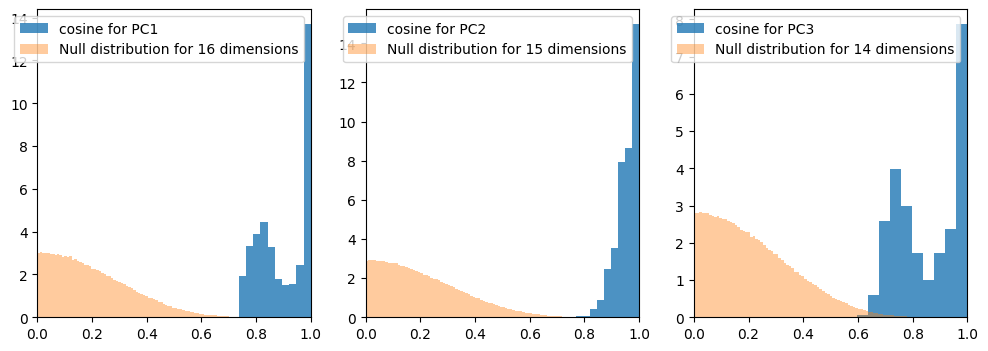

In [93]:
import seaborn as sns

all_post_comps_stacked = torch.tensor(np.stack(all_post_comps, 1))  # [3D, difference probe combinations, N = 16]
print(all_post_comps_stacked.shape)

triu_indices = torch.triu_indices(len(all_post_comps), len(all_post_comps), 1)
all_post_comps_cosines = [torch.mm(vecs, vecs.T).abs()[*triu_indices] for vecs in all_post_comps_stacked]

fig, axes = plt.subplots(1, 3, figsize = (12, 4), sharex = True)
for i, (ax, apcc) in enumerate(zip(axes, all_post_comps_cosines[:3])):

    ax.hist(apcc.numpy(), 10, density = True, alpha = 0.8, label = f'cosine for PC{i+1}')
    test_pop_size = 1024

    random_vectors = torch.randn(test_pop_size, 16 - i)
    random_vectors = random_vectors / random_vectors.square().sum(-1)[:,None].sqrt()

    assert torch.isclose(random_vectors.square().sum(-1), torch.tensor(1.0)).all()

    test_pop_cosines = torch.mm(random_vectors, random_vectors.T)[*torch.triu_indices(test_pop_size, test_pop_size, 1)].abs()
    assert test_pop_cosines.shape[0] == (test_pop_size * (test_pop_size-1) * 0.5)

    ax.hist(test_pop_cosines.numpy(), 100, density = True, alpha = 0.4, label = f"Null distribution for {16 - i} dimensions")

    ax.set_xlim(0, 1)
    ax.legend()

In [94]:
len(all_projection_pcaed), all_projection_pcaed[0].shape, len(all_many_trials_swapped_trials), all_many_trials_swapped_trials[0].shape

(90, (608, 4), 90, torch.Size([608]))

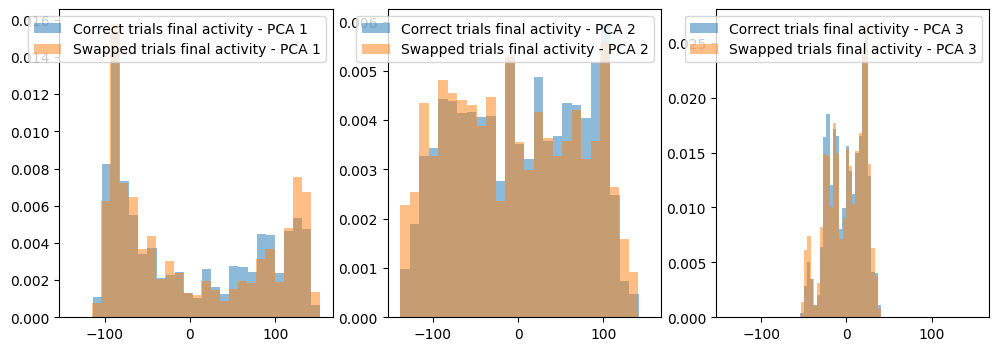

In [95]:
all_swaped_pcas = np.concatenate([pca4[pcast] for pca4, pcast in zip(all_projection_pcaed, all_many_trials_swapped_trials)], 0)
all_nonswaped_pcas = np.concatenate([pca4[~pcast] for pca4, pcast in zip(all_projection_pcaed, all_many_trials_swapped_trials)], 0)

fig, axes = plt.subplots(1, 3, figsize = (12, 4), sharex = True)
for i, (sp, nsp) in enumerate(zip(all_swaped_pcas, all_nonswaped_pcas[:3])):
    axes[i].hist(all_nonswaped_pcas[:,i], 25, alpha = 0.5, label = f'Correct trials final activity - PCA {i+1}', density = True)
    axes[i].hist(all_swaped_pcas[:,i], 25, alpha = 0.5, label = f'Swapped trials final activity - PCA {i+1}', density = True)
    axes[i].legend()